In [5]:
from datetime import datetime
from fredapi import Fred
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import numpy as np
import pandas as pd
import pandas_ta as ta
import pytz
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import yfinance as yf

# Connect to yfinance and collect data
def yf_data():

    tickers = {
    '^GSPC': 'SPY',
    '^VIX': 'VIX',
    '^DJI': 'DJI',
    '^IXIC': 'Nasdaq',
    '^RUT': 'RUSSELL 2000',
    '^GDAXI': 'DAX',
    '^FTSE': 'FTSE',
    '^FCHI': 'CAC',
    '^HSI': 'HSI',
    '000001.SS': 'SSE',
    '^N225': 'Nikkei',
    'XLE': 'ENERGY',
    'XLF': 'FINANCIALS',
    'XLK': 'TECHNOLOGY',
    'XLV': 'HEALTHCARE',
    'XLP': 'CONSUMER STAPLES',
    'XLI': 'INDUSTRIALS',
    'XLU': 'UTLITIES',
    'XLY': 'CONSUMER DISCRETIONARY',
    'XLB': 'MATERIALS',
    '^FVX': '5Y YIELD',
    '^TNX': '10Y YIELD',
    '^TYX': '30Y YIELD',
}
    daily_returns_df = pd.DataFrame()

    utc_tz = pytz.timezone('Etc/UTC')

    for symbol, name in tickers.items():
        ticker_data = yf.download(symbol, interval='1d', start="2003-01-01", end="2023-01-07")['Close']
        ticker_data.index = ticker_data.index.tz_localize('UTC').tz_convert(utc_tz)
        # Calculate daily return from close
        daily_returns = ticker_data.pct_change().apply(lambda x: np.log(1 + x)) * 100
        daily_returns_df[name] = daily_returns
        
        # Forward fill NaN values
        filled_daily_returns_df = daily_returns_df.ffill()
        # Drop remaining NaN values
        filtered_daily_returns_df = filled_daily_returns_df.dropna()
        

    return filtered_daily_returns_df

# collect spy volume and other TA
def spy_ta():
    tickers = ['SPY']
    start_date = '2003-01-01'
    end_date = '2023-01-07'

    # Fetch historical data from Yahoo Finance
    data = yf.download(tickers, start=start_date, end=end_date)
    volume = yf.download(tickers, start=start_date, end=end_date)['Volume']

    # Convert index to UTC timezone
    utc_tz = pytz.timezone('Etc/UTC')
    data.index = data.index.tz_localize('UTC').tz_convert(utc_tz)
    volume.index = volume.index.tz_localize('UTC').tz_convert(utc_tz)
    data = pd.DataFrame(data)
    volume = pd.DataFrame(volume)

    # simple moving average for 5,10,20 days
    data.ta.sma(length=5, append=True)
    data.ta.sma(length=10, append=True)
    data.ta.sma(length=20, append=True)
    # exponential moving average for 5,10,20 days
    data.ta.ema(length=5, append=True)
    data.ta.ema(length=10, append=True)
    data.ta.ema(length=20, append=True)
    # rsi for 7,14,20 days
    data.ta.rsi(length=7, append=True)
    data.ta.rsi(length=14, append=True)
    data.ta.rsi(length=20, append=True)
    # atr for 14 days
    data.ta.atr(length=14, append=True)
    data.ta.obv(high='high', low='low', close='close', volume='volume', append=True)
    

    ta_data = pd.concat([data, volume], axis=1)

    return ta_data

    
# Connect to FRED and collect economic data
def fed_data():

    indicators = {
        'CPIAUCSL': 'CPI',
        'MEDCPIM158SFRBCLE': 'MEDIAN CPI',
        'STICKCPIM157SFRBATL': 'STICKY CPI',
        'PCE': 'PCE',
        'PSAVERT': 'PERSONAL SAVINGS',
        'PPIACO': 'PPI (ALL COMMODITIES)',
        'T10YIE': '10Y EXPECTED INFLATION',
        'T5YIE' : '5Y EXPECTED INFLATION',
        'EXPINF1YR': '1Y EXPECTED INFLATION',
        'EXPINF2YR': '2Y EXPECTED INFLATION',
        'DCOILBRENTEU': 'BRENT',
        'DCOILWTICO': 'WTI',
        'T10Y2Y': '10Y-2Y: YIELD CURVE',
        'DGS1MO': '1M TBILL',
        'DTB3': '3M TBILL',
        'RPTTLD': 'FED OPEN MARKET OPERATIONS: TOTAL SECURITIES',
        'M1SL': 'M1',
        'WM2NS': 'M2',
        'BAMLC0A1CAAAEY': 'AAA YIELD',
        'USALORSGPNOSTSAM': 'US GDP',
        'GEPUCURRENT': 'POLICY UNCERTAINTY INDEX',
        'TLRESCONS': 'RESIDENTIAL CONSTRUCTION SPENDING',
        'HOUST': 'NEW PRIVATE HOUSING',
    }
    utc_tz = pytz.timezone('Etc/UTC')

    fred = Fred(api_key='7cdaa2609ea03808ab1cd13fcb0ad384')
    indicator_data_dict = {}

    for tag, indicator_name in indicators.items():
        data = fred.get_series_latest_release(tag)
        data.index = pd.to_datetime(data.index).tz_localize('UTC').tz_convert(utc_tz)
        indicator_data_dict[indicator_name] = data

    # Concatenate data and forward fill NaN values
    indicator_data_df = pd.concat(indicator_data_dict.values(), axis=1, keys=indicator_data_dict.keys())
    indicator_data_df.ffill(inplace=True)

    # Filter data for the desired date range
    start_date = datetime(2003, 1, 1).replace(tzinfo=utc_tz)
    end_date = datetime(2023, 1, 1).replace(tzinfo=utc_tz)
    indicator_data_df = indicator_data_df.loc[start_date:end_date]
    return indicator_data_df

# connect to mt5 and collect forex data
def collect_forex_data():
    forex_symbols = ['EURUSD', 'USDJPY', 'AUDUSD', 'USDCAD']
    forex_dataframes = []
    # set dates to utc
    timezone = pytz.timezone("Etc/UTC")
    start_date = datetime(2003, 1, 1)
    end_date = datetime(2023, 1, 2)
    utc_from = datetime(start_date.year, start_date.month, start_date.day, tzinfo=timezone)
    utc_to = datetime(end_date.year, end_date.month, end_date.day, hour=23, minute=59, second=59, tzinfo=timezone)
    
    timezone = pytz.timezone("Etc/UTC")
    start_date = datetime(2003, 1, 1)
    end_date = datetime(2023, 1, 2)
    utc_from = timezone.localize(datetime(start_date.year, start_date.month, start_date.day))
    utc_to = timezone.localize(datetime(end_date.year, end_date.month, end_date.day, hour=23, minute=59, second=59))
    
    for symbol in forex_symbols:
        mt5.initialize()
        forex_data = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_D1, utc_from, utc_to)
        forex_df = pd.DataFrame(forex_data, columns=['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume'])
        forex_df['time'] = pd.to_datetime(forex_df['time'], unit='s')
        forex_df['time'] = forex_df['time'].dt.tz_localize(timezone)  # Localize the time column
        forex_df.set_index('time', inplace=True)
        symbol_close = forex_df['close']
        symbol_returns = symbol_close.pct_change() * 100
        symbol_returns = symbol_returns.rename(f'{symbol}')
        # ffill Nan values
        symbol_returns = symbol_returns.ffill()
        # drop remaining Nan
        symbol_returns = symbol_returns.dropna()
        forex_dataframes.append(symbol_returns)
        mt5.shutdown()

    return pd.concat(forex_dataframes, axis=1)

# correlation analysis
def correlation_test(dataframe):
    correlation_matrix = dataframe.corr()
    sns.heatmap(correlation_matrix, cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.show()

# stationarize data
def station_data(dataframe):
    for column in dataframe.columns:
        # Perform seasonal adjustment
        decomposition = seasonal_decompose(dataframe[column], model='additive', period=1)
        dataframe[column + '_seasonally_adjusted'] = decomposition.trend

        # Differencing to make the series stationary
        dataframe[column + '_stationary'] = dataframe[column + '_seasonally_adjusted'].diff()

    # Drop NaN values resulted from differencing
    dataframe = dataframe.dropna()

    return dataframe

# adf test for market data
def adf_test(dataframe):
    results = {}
    for column in dataframe.columns:
        adf_result = adfuller(dataframe[column])
        results[column] = {
            'Test Statistic': adf_result[0],
            'P-Value': adf_result[1],
            'Lags Used': adf_result[2],
            'Number of Observations Used': adf_result[3],
            'Critical Values': adf_result[4]
        }
    
    adf_results_df = pd.DataFrame(results).T
    return adf_results_df

# principal component analysis if needed
def apply_pca(dataframe):
    features = dataframe.drop(columns='SPY')
    target = dataframe['SPY']
    # apply standardization 
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    pca = PCA(n_components=0.95)
    features_pca = pca.fit_transform(scaled_features)

    # Check the explained variance ratio for each component
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained Variance Ratio:", explained_variance_ratio)

    # Check the cumulative explained variance
    cumulative_explained_variance = explained_variance_ratio.cumsum()
    print("Cumulative Explained Variance:", cumulative_explained_variance)

    # plot for explained variance
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
    plt.title('Screen Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.show()

    # plot for cumulative variance
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
    plt.title('Cumulative Explained Variance Plot')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()

    return features_pca



In [6]:
# equities data
filtered_daily_return_df = yf_data()
print(filtered_daily_return_df)
# adf test on equity data
equity_adf_results = adf_test(filtered_daily_return_df)
print(equity_adf_results)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [7]:
# macroeconomic data
indicator_data_df = fed_data()
indicator_data_df = indicator_data_df.dropna()
# stationarise data
indicator_data_df = station_data(indicator_data_df)
# adf test
indicator_adf_results = adf_test(indicator_data_df)
print(indicator_adf_results)


                                                   Test Statistic   P-Value  \
CPI                                                      2.050318  0.998735   
MEDIAN CPI                                              -2.179818  0.213652   
STICKY CPI                                              -3.892992  0.002087   
PCE                                                      1.038155  0.994653   
PERSONAL SAVINGS                                        -3.612776  0.005521   
...                                                           ...       ...   
POLICY UNCERTAINTY INDEX_stationary                    -19.592936       0.0   
RESIDENTIAL CONSTRUCTION SPENDING_seasonally_ad...      -0.040925  0.955014   
RESIDENTIAL CONSTRUCTION SPENDING_stationary            -6.451381       0.0   
NEW PRIVATE HOUSING_seasonally_adjusted                 -1.447503  0.559303   
NEW PRIVATE HOUSING_stationary                         -21.354238       0.0   

                                                   

In [8]:
# forex data
forex_data = collect_forex_data()
forex_data = forex_data.dropna()
# adf test
forex_adf_results = adf_test(forex_data)
print(forex_adf_results)

       Test Statistic P-Value Lags Used Number of Observations Used  \
EURUSD     -73.202002     0.0         0                        5195   
USDJPY     -74.835711     0.0         0                        5195   
AUDUSD     -24.757083     0.0         8                        5187   
USDCAD     -12.438461     0.0        32                        5163   

                                          Critical Values  
EURUSD  {'1%': -3.4316093905923193, '5%': -2.862096519...  
USDJPY  {'1%': -3.4316093905923193, '5%': -2.862096519...  
AUDUSD  {'1%': -3.4316113339347782, '5%': -2.862097377...  
USDCAD  {'1%': -3.4316172001143523, '5%': -2.862099969...  


In [9]:
# technical analysis features
ta_data = spy_ta()
print(ta_data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                                 Open        High         Low       Close  \
Date                                                                        
2003-01-02 00:00:00+00:00   88.849998   91.300003   88.540001   91.070000   
2003-01-03 00:00:00+00:00   90.910004   91.379997   90.500000   91.349998   
2003-01-06 00:00:00+00:00   91.239998   93.489998   91.169998   92.959999   
2003-01-07 00:00:00+00:00   92.900002   93.370003   92.199997   92.730003   
2003-01-08 00:00:00+00:00   92.199997   92.400002   91.050003   91.389999   
...                               ...         ...         ...         ...   
2022-12-30 00:00:00+00:00  380.640015  382.579987  378.429993  382.429993   
2023-01-03 00:00:00+00:00  384.369995  386.429993  377.829987  380.820007   
2023-01-04 00:00:00+00:00  383.179993  385.880005  380.000000  383.760010   
2023-01-05 00:0

In [14]:
# combine all data
combined_data = pd.concat([filtered_daily_return_df, indicator_data_df, forex_data, ta_data], axis=1)
clean_combined_data = combined_data.dropna()
print(clean_combined_data)

                                SPY       VIX       DJI    Nasdaq  \
2003-01-31 00:00:00+00:00  1.304490 -0.480077  1.358613 -0.108952   
2003-02-03 00:00:00+00:00  0.538456 -0.482392  0.693037  0.217795   
2003-02-04 00:00:00+00:00 -1.418795  5.457604 -1.197423 -1.341497   
2003-02-05 00:00:00+00:00 -0.544985  0.851077 -0.351407 -0.356645   
2003-02-06 00:00:00+00:00 -0.646952  0.933875 -0.702261  0.017669   
...                             ...       ...       ...       ...   
2022-12-23 00:00:00+00:00  0.585095 -5.136509  0.532804  0.207307   
2022-12-27 00:00:00+00:00 -0.405784  3.669268  0.113262 -1.387287   
2022-12-28 00:00:00+00:00 -1.209347  2.238046 -1.106674 -1.360878   
2022-12-29 00:00:00+00:00  1.731063 -3.212754  1.044209  2.559658   
2022-12-30 00:00:00+00:00 -0.254398  1.067046 -0.221645 -0.110858   

                           RUSSELL 2000       DAX      FTSE       CAC  \
2003-01-31 00:00:00+00:00      1.230099  1.986612 -0.316258  0.811691   
2003-02-03 00:00:00+00:00

Explained Variance Ratio: [0.23012988 0.12658253 0.1183079  0.06285858 0.03735327 0.03346669
 0.03128298 0.02403499 0.02221202 0.018836   0.01710646 0.01637403
 0.01479958 0.01394362 0.01327974 0.01227891 0.01144952 0.01081176
 0.01024376 0.00988961 0.0091231  0.00867582 0.00836661 0.00801805
 0.00763006 0.00735702 0.00685703 0.00675369 0.00658499 0.00580839
 0.00528852 0.00513306 0.00469434 0.00415659 0.00395276 0.00386739
 0.00368796 0.00363555 0.00354301 0.00346654]
Cumulative Explained Variance: [0.23012988 0.35671242 0.47502031 0.53787889 0.57523216 0.60869884
 0.63998183 0.66401682 0.68622885 0.70506485 0.72217131 0.73854534
 0.75334492 0.76728855 0.78056828 0.79284719 0.80429671 0.81510847
 0.82535223 0.83524184 0.84436494 0.85304075 0.86140736 0.86942541
 0.87705547 0.8844125  0.89126953 0.89802321 0.90460821 0.9104166
 0.91570513 0.92083818 0.92553253 0.92968911 0.93364187 0.93750926
 0.94119722 0.94483277 0.94837579 0.95184232]


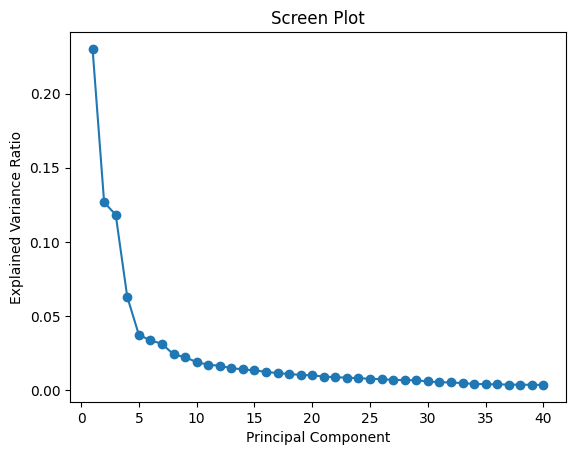

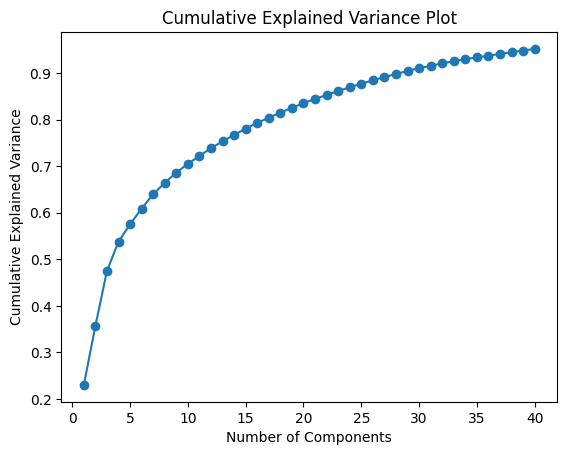

In [15]:
# apply pca
data_pca = apply_pca(clean_combined_data)

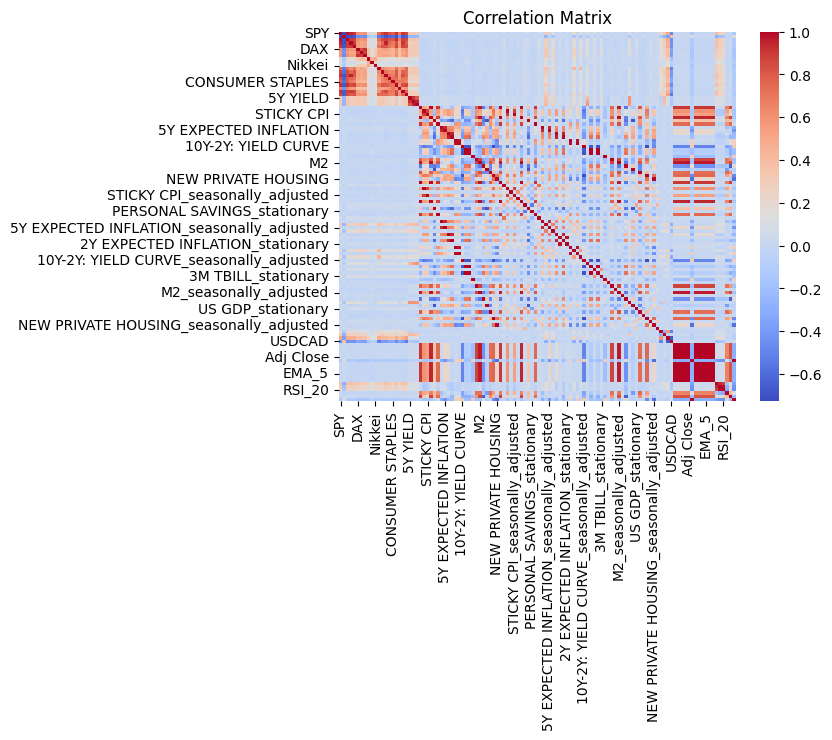

In [ ]:
# create correlation heatmap
heatmap = correlation_test(clean_combined_data)